In [1]:
import charts_function_list
import os
from PIL import Image

In [2]:
_,data,outputs = charts_function_list.folder_setup()
lego = os.path.join(data,'lego-database')
os.chdir(lego)

In [3]:
lego = os.path.join(data,'lego-database')
df_values = [x.split('.csv')[0] for x in os.listdir(lego)] 
df_values.remove('downloads_schema.png') #known non .csv

#set dictionary of all csvs
lego_d = {i:pd.read_csv(i+'.csv') for i in df_values}

In [4]:
#function to convert hex to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

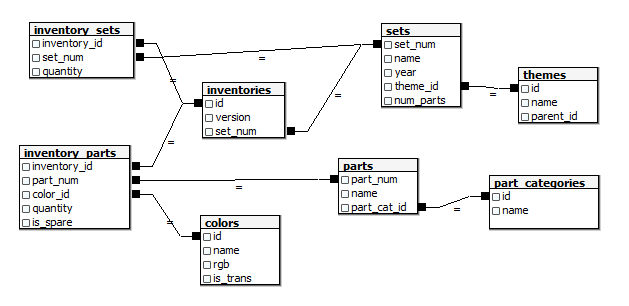

In [5]:
Image.open('downloads_schema.png')

### Idea 2 - 

* Do a size comparison of different piece categories
* or a wild crosstab with color

**plan of attack**



## Create new combined frames

In [6]:


#combined_sets = pd.merge(lego_d["sets"],lego_d["inventory_sets"],on="set_num",how='left')
combined_sets = pd.merge(lego_d["inventories"],lego_d["sets"],on='set_num',how='left')
combined_sets = pd.merge(combined_sets,lego_d["themes"],left_on='theme_id',right_on='id',how='left',suffixes=('_of_set','_of_theme'))

#combining parts and other tables
combined_parts = pd.merge(lego_d["inventory_parts"],lego_d["parts"],on='part_num',how='left')
combined_parts = pd.merge(combined_parts, lego_d["part_categories"],left_on='part_cat_id',right_on='id',how='left',suffixes=('_of_part','_of_part_category'))
combined_parts = pd.merge(combined_parts,lego_d["colors"],left_on='color_id',right_on='id',how='left')
combined_parts = combined_parts.drop(['id_x','id_y'],axis=1)

In [28]:
part_count = combined_parts.pivot_table('quantity',index='rgb',aggfunc='sum').reset_index()
part_count = pd.concat([part_count,pd.DataFrame(list(part_count.reset_index()['rgb'].apply(hex_to_rgb)),columns=['R','G','B'])],
          axis=1)

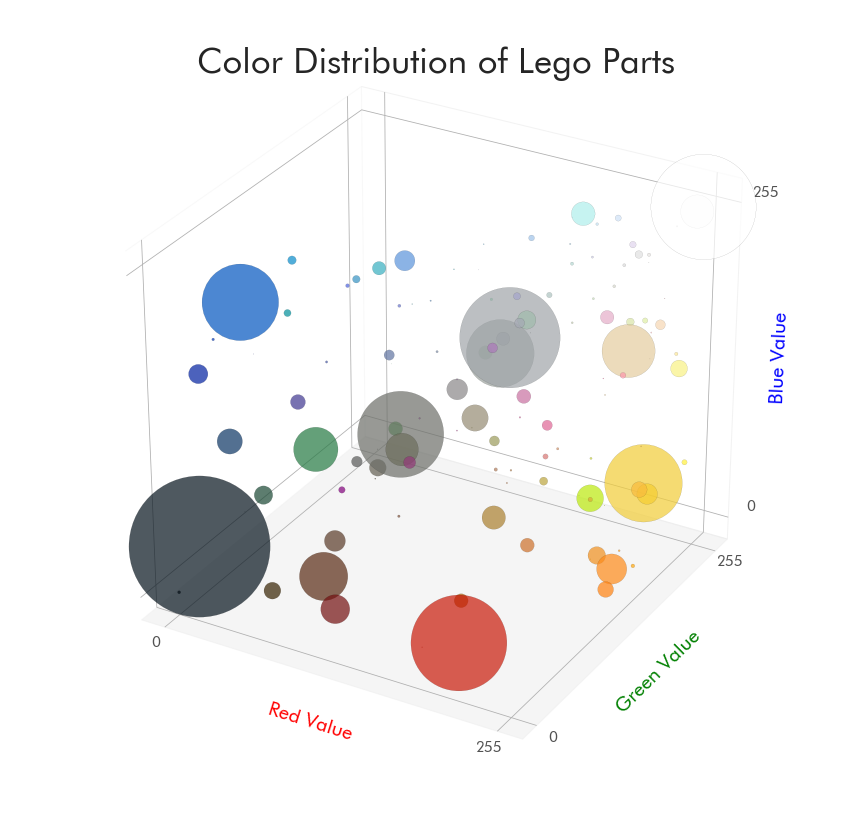

In [30]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,12))
fig.suptitle('Color Distribution of Lego Parts',size=35,color='#252525',x=.52)
fig.subplots_adjust(top=.99)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(part_count['R'],part_count['G'],part_count['B'],s=part_count['quantity']/20,c='#'+part_count['rgb'],alpha=.7,
           edgecolor='black',linewidth=.1)

#ax.scatter(255,255,255,s=part_count[part_count['rgb']=='FFFFFF']['quantity'].values/20,c='#FFFFFF',alpha=.8,
 #          edgecolor='black',linewidth=.5)

ax.set_xlabel('Red Value',fontsize=20,color='red')
ax.set_ylabel('Green Value',fontsize=20,color='green')
ax.set_zlabel('Blue Value',fontsize=20,color='blue')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = True
#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_xaxis.set_ticks([0,255])
ax.w_yaxis.set_ticks([0,255])
ax.w_zaxis.set_ticks([0,255])
ax.w_xaxis.set_ticks_position('none') 

for t1 in ax.xaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.yaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.zaxis.get_ticklines():
    t1.set_visible(False)

ax.tick_params(labelsize=15,labelcolor='#525252',labeltop=True,
               labelbottom=False,labelleft=False,labelright=True,pad=8)

In [31]:
part_counts = combined_parts.pivot_table('quantity',index='name_of_part_category',aggfunc='sum')

In [34]:
part_counts

,quantity
name_of_part_category,
"Bars, Ladders and Fences",26496
Baseplates,1544
"Belville, Scala and Fabuland",768
"Bionicle, Hero Factory and Constraction",15751
Bricks,321105
Bricks Curved,38560
Bricks Printed,4580
Bricks Round and Cones,48525
Bricks Sloped,127042
